## Protein Hunter Chai

In [1]:
import os
import gc
import re
import torch
import py2Dmol
from chai_ph.pipeline import optimize_protein_design, sample_seq, is_smiles, clean_protein_sequence
from chai_ph.predict import ChaiFolder
from LigandMPNN.wrapper import LigandMPNNWrapper

In [2]:
gpu_id = 0
folder = ChaiFolder(device=f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
work_dir = os.getcwd()
designer = LigandMPNNWrapper(os.path.join(work_dir, "LigandMPNN/run.py"))

<IPython.core.display.Javascript object>

Initial seq: XXKXFWLXYYXXKFAXDGXXXECXXXXAXXWEXXXQXXSXEKXIXLLELWXTSXWXDXEVXXXXCQMXXXKTXIYAFSTXXEXXQKHXXXALXHIAXXXYXIXXHYMXXXXDXESEXXMXXXNWQXXVXXWRCIGDXXAXXXXXXXGWXX


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

./results_chai_notebook/ligand_binder_test/run_0 | Step 0: score=0.173 plddt=0.5 ptm=0.388 iptm=0.120 ipae=12.92 ala=6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

./results_chai_notebook/ligand_binder_test/run_0 | Step 1: score=0.511 plddt=0.9 ptm=0.902 iptm=0.414 ipae=4.64 ala=12 rmsd=10.75


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

./results_chai_notebook/ligand_binder_test/run_0 | Step 2: score=0.700 plddt=0.9 ptm=0.942 iptm=0.640 ipae=2.55 ala=23 rmsd=2.37


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

./results_chai_notebook/ligand_binder_test/run_0 | Step 3: score=0.774 plddt=0.9 ptm=0.956 iptm=0.729 ipae=2.31 ala=20 rmsd=0.86


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

./results_chai_notebook/ligand_binder_test/run_0 | Step 4: score=0.413 plddt=0.9 ptm=0.904 iptm=0.290 ipae=5.96 ala=16 rmsd=3.57


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

./results_chai_notebook/ligand_binder_test/run_0 | Step 5: score=0.576 plddt=0.9 ptm=0.938 iptm=0.486 ipae=3.69 ala=23 rmsd=1.13


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

./results_chai_notebook/ligand_binder_test/run_0 | Step 6: score=0.818 plddt=0.9 ptm=0.960 iptm=0.782 ipae=2.23 ala=20 rmsd=0.56


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

./results_chai_notebook/ligand_binder_test/run_0 | Step 7: score=0.724 plddt=0.9 ptm=0.954 iptm=0.666 ipae=2.45 ala=23 rmsd=2.83


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

./results_chai_notebook/ligand_binder_test/run_0 | Step 8: score=0.722 plddt=0.9 ptm=0.951 iptm=0.665 ipae=2.53 ala=23 rmsd=1.26


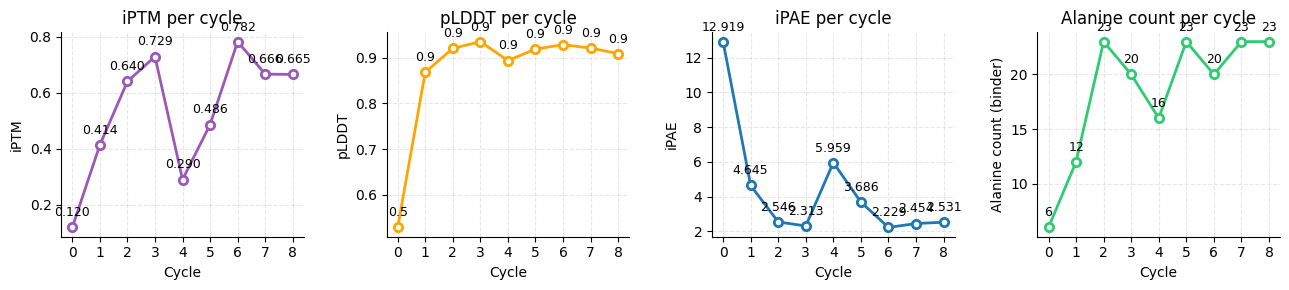

./results_chai_notebook/ligand_binder_test/run_0 | Final Validation: score=0.839 plddt=0.9 ptm=0.963 iptm=0.808 ipae=1.71 ala=20 rmsd=1.62


In [ ]:
# @title RUN
# @markdown input options
# @markdown -----
jobname = "ligand_binder_test" # @param {"type":"string"}
binder_chain = "A" # @param {"type":"string"}
length = 150 # @param {"type":"integer"}
percent_X = 50 # @param ["0","50","100"] {"type":"raw"}

# @markdown optional settings
seq = "" # @param {"type":"string"}
target_chain = "B" # @param {"type":"string"}
target_seq = "O=C(NCc1cocn1)c1cnn(C)c1C(=O)Nc1ccn2cc(nc2n1)c1ccccc1" # @param {"type":"string"}
target_pdb = None # @param {"type":"string"}
target_pdb_chain = None # @param {"type":"string"}
cyclic = False # @param {"type":"boolean"}

# @markdown optimization options
# @markdown -----
n_trials = 1 # @param ["1","2","4","8","16"] {"type":"raw"}
n_cycles = 8 # @param ["0","1","2","3","5","10"] {"type":"raw"}
n_recycles = 3 # @param ["1","2","3"] {"type":"raw"}
n_diff_steps = 200 # @param ["50","100","200"] {"type":"raw"}
hysteresis_mode = "esm" # @param ["templates","esm","partial_diffusion", "none"]
repredict = True # @param {"type":"boolean"}

# @markdown mpnn options
# @markdown -----
omit_aa = "C" # @param {"type":"string"}
bias_aa = "" # @param {"type":"string"} A:-0.5
temperature = 0.01 # @param ["0.01","0.1","1.0"] {"type":"raw"}
scale_temp_by_plddt = False # @param {"type":"boolean"}
high_iptm_threshold = 0.8 # @param ["0.8","0.9","1.0"] {"type":"raw"}
# @markdown visual options
# @markdown -----
show_visual = True # @param {"type":"boolean"}
render_freq = 100 # @param ["1","10","100"] {"type":"raw"}
plot = True # @param {"type":"boolean"} 

###############
# Parsing opts
###############

jobname = re.sub(r'\W+', '', jobname)
def check(folder): return os.path.exists(folder)
if check(jobname):
  n = 0
  while check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

binder_mode = "none"
if is_smiles(target_seq):
  binder_mode = "ligand"
else:
  target_seq = clean_protein_sequence(target_seq)
  if target_seq == "":
    target_seq = None
  else:
    binder_mode = "protein"

seq = clean_protein_sequence(seq)

omit_AA = clean_protein_sequence(omit_aa)
bias_AA = bias_aa
if omit_AA == "": omit_AA = None
if bias_AA == "": bias_AA = None

if show_visual:
  viewer = py2Dmol.view((600,400), color="plddt")
  viewer.show()
else:
  viewer = None

#####################
# hysteresis_mode
#####################
opts = dict(use_esm=False,
            use_esm_target=binder_mode == "protein",
            pde_cutoff_intra=0.0,
            pde_cutoff_inter=0.0,
            partial_diffusion=0.0)
if hysteresis_mode == "templates":
  opts["pde_cutoff_intra"] = 1.5
  opts["pde_cutoff_inter"] = 3.0
elif hysteresis_mode == "esm":
  opts["use_esm"] = True
  opts["use_esm_target"] = True
elif hysteresis_mode == "partial_diffusion":
  opts["partial_diffusion"] = 0.5

# Initialize folder and designer only if they don't exist
# This allows re-running the cell without re-initializing if desired,
# but the cleanup at the end will handle memory if run multiple times.
if "folder" not in locals() or folder is None:
    folder = ChaiFolder(device="cuda:0" if torch.cuda.is_available() else "cpu")
if "designer" not in locals() or designer is None:
    designer = LigandMPNNWrapper()

X = []
for t in range(n_trials):
  if seq == "":
    trial_seq = sample_seq(length, frac_X=percent_X/100)
  else:
    trial_seq = seq

  if viewer is not None:
    viewer.new_obj()

  x = optimize_protein_design(
      folder,
      designer,
      initial_seq=trial_seq,
      binder_chain=binder_chain,
      target_seq=target_seq,
      target_chain=target_chain,
      target_pdb=target_pdb,
      target_pdb_chain=target_pdb_chain,
      prefix=f"./results_chai_notebook/{jobname}/run_{t}",
      n_steps=n_cycles,
      num_trunk_recycles=n_recycles,
      num_diffn_timesteps=n_diff_steps,
      num_diffn_samples=1,
      temperature=temperature,
      scale_temp_by_plddt=scale_temp_by_plddt,
      use_alignment=True,
      align_to="all",
      randomize_template_sequence=True,
      high_iptm_threshold=high_iptm_threshold,
      omit_AA=omit_AA,
      bias_AA=bias_AA,
      cyclic=cyclic,
      verbose=False,
      viewer=viewer,
      render_freq=render_freq,
      final_validation=repredict,
      plot=plot,
      **opts
  )
  X.append(x)

  folder.full_cleanup()
  # Explicitly clear memory between trials
  gc.collect()
  if torch.cuda.is_available():
      torch.cuda.empty_cache()

#########################
# restore best of best
#########################
best_sco = 0
best_n = None
# Check if X is not empty before proceeding
if X:
    for n,x in enumerate(X):
      # Ensure result and ranking_score exist
      if x and x.get("state") and x["state"].result and "ranking_score" in x["state"].result:
          if x["state"].result["ranking_score"] > best_sco:
            best_sco = x["state"].result["ranking_score"]
            best_n = n
      else:
            print(f"Warning: Skipping trial {n} for best selection due to missing data.")
      folder.restore_state(X[best_n]["state"])
else:
    print("Warning: No successful trials completed.")

In [4]:
# @title Plot
folder.plot(color_by="plddt")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.